# Prepare data required for creating a plant simulation

## Load required packages

In [1]:
# Import packages
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
from distfit import distfit
from tqdm.notebook import tqdm

## Import data

In [2]:
# Load data
data_sessions = pd.read_csv("../data/external/data_sessions.csv")

## Data description

In [3]:
# Inspect the shape of the data frame
print("Dataframe shape of the data:", data_sessions.shape)

Dataframe shape of the data: (14419, 3)


In [4]:
# Show information about the data frame
data_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14419 entries, 0 to 14418
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     14419 non-null  int64  
 1   seconds_working_clock  14419 non-null  float64
 2   product_id             14419 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 338.1 KB


In [5]:
# Show the data
data_sessions.head()

,id,seconds_working_clock,product_id
0,0,13.0,1841.0
1,1,205.0,1841.0
2,2,17.0,1841.0
3,3,5.0,1435.0
4,4,16.0,1435.0


<AxesSubplot: >

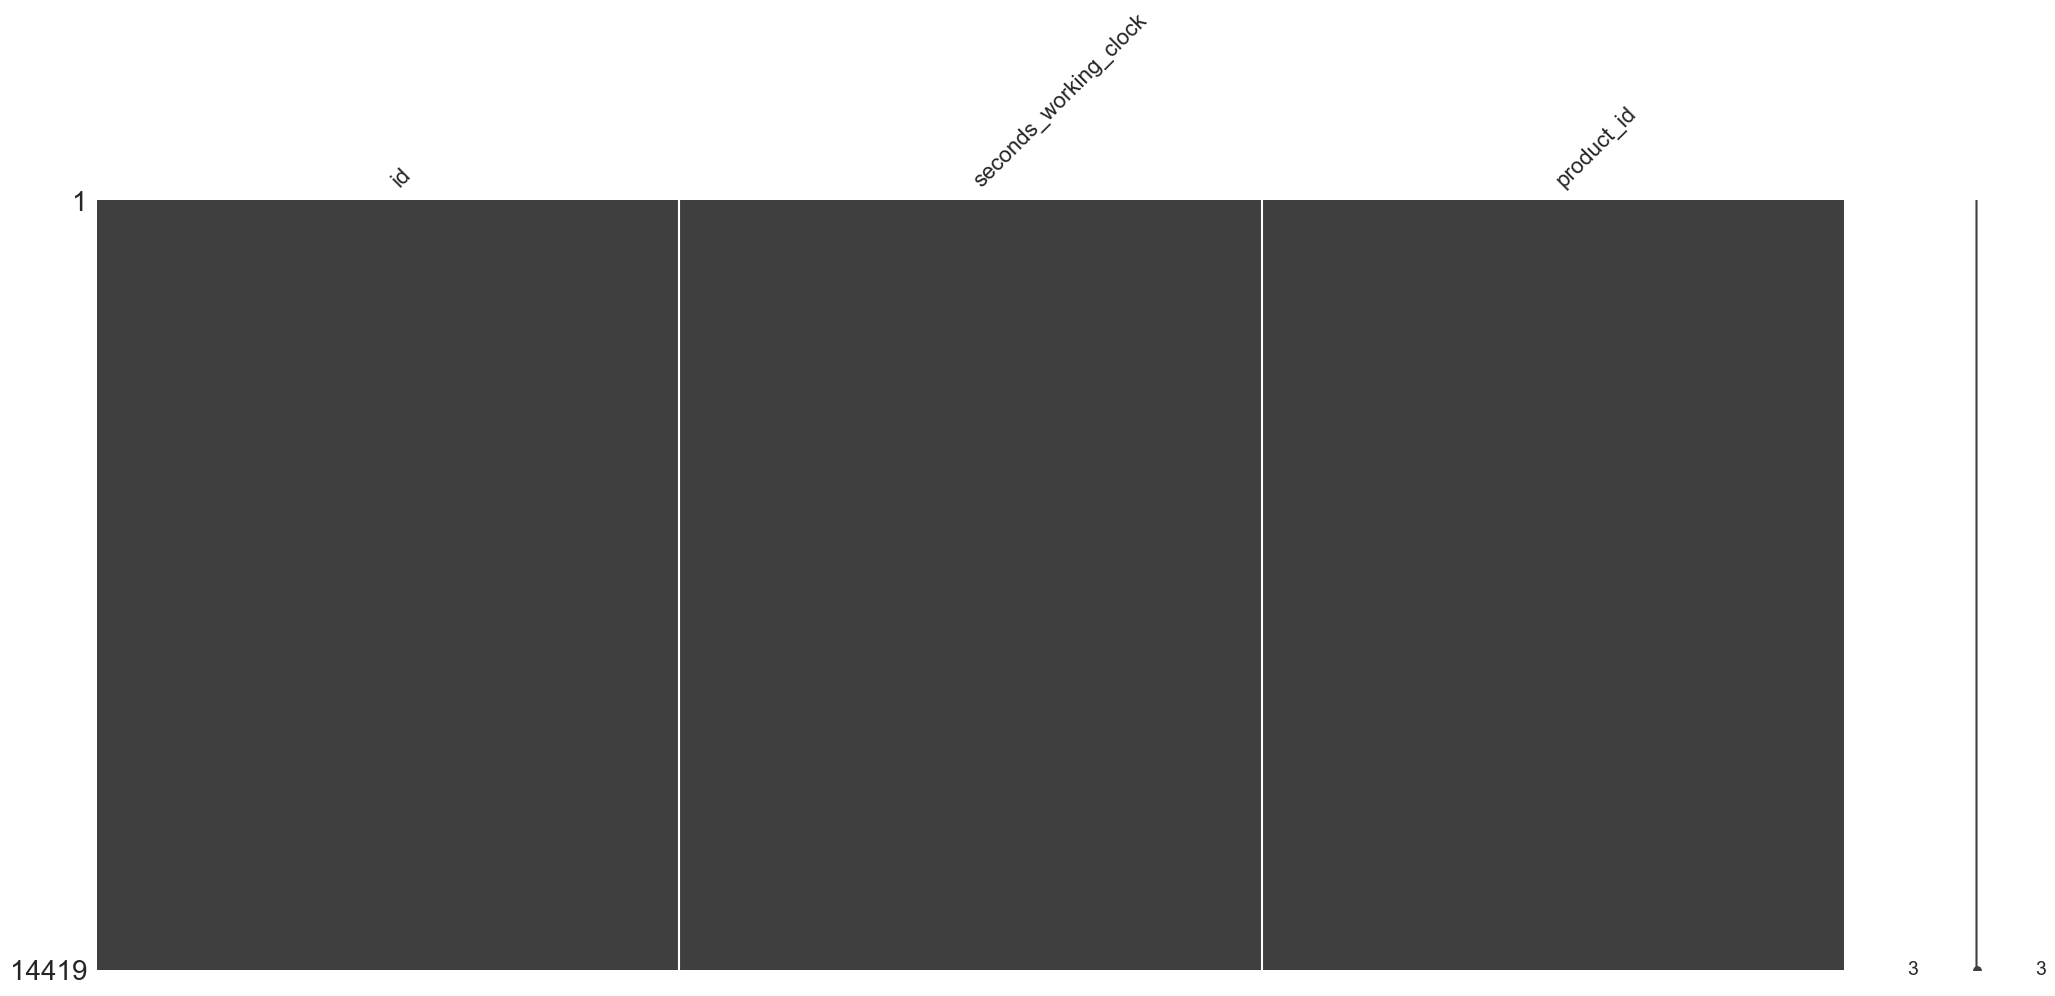

In [6]:
# Plot missing data
msno.matrix(data_sessions)

We do not have any missing data.

In [7]:
# Check amount of unique values for the variables
data_sessions.nunique()

id                       14419
seconds_working_clock     3249
product_id                 254
dtype: int64

## Analyse seconds working clock

In [8]:
# Describe the distribution of the variable
data_sessions.seconds_working_clock.describe()

count    14419.000000
mean       924.621402
std       2581.770721
min     -82346.000000
25%          8.000000
50%        308.000000
75%        903.000000
max      82707.000000
Name: seconds_working_clock, dtype: float64

In [9]:
# Check data below 0 
data_sessions[data_sessions.seconds_working_clock <= 0].seconds_working_clock.describe()

count      682.000000
mean      -736.523460
std       5603.206643
min     -82346.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.000000
Name: seconds_working_clock, dtype: float64

In [10]:
# Check data below 120
data_sessions[np.logical_and(data_sessions.seconds_working_clock <= 120,
                             data_sessions.seconds_working_clock > 0)].seconds_working_clock.describe()

count    4808.000000
mean       14.945923
std        22.455503
min         1.000000
25%         5.000000
50%         6.000000
75%        12.000000
max       120.000000
Name: seconds_working_clock, dtype: float64

<AxesSubplot: xlabel='seconds_working_clock'>

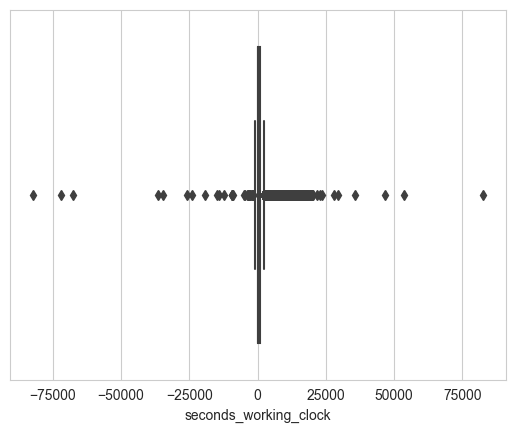

In [11]:
# Plot a boxplot of the variable distribution
sns.boxplot(x=data_sessions["seconds_working_clock"])

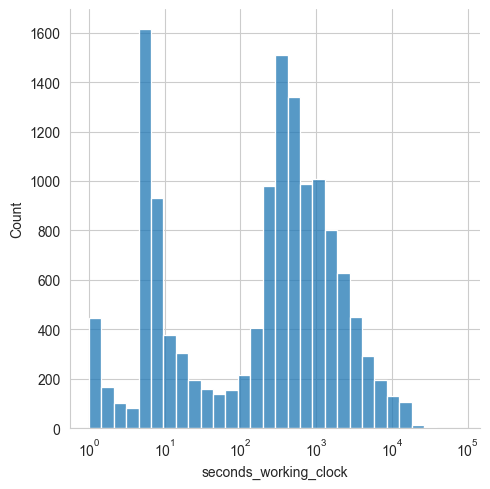

In [12]:
# Visualise data distribution
sns.displot(data_sessions[data_sessions.seconds_working_clock > 0], x="seconds_working_clock", log_scale = True)

In [13]:
# Check distribution of data points for products
data_sessions["product_id"].value_counts().describe()

count    254.000000
mean      56.767717
std      111.307488
min        1.000000
25%        6.000000
50%       15.000000
75%       62.000000
max      960.000000
Name: product_id, dtype: float64

Based on the data analysis we can see that the quality of the data is not perfect and further preprocessing is required.

## Preprocess data

An important task in preprocessing this is the filter out outlier. Reasons for outlier are mainly based on false usage of the digital twin technology, which leads to very short or very long periods. They have to be filtered out manually.

In [14]:
# Drop all values below 120 seconds as this short processing time is not possible in real production
data_sessions = data_sessions[data_sessions["seconds_working_clock"] > 120]

Additionally, we can remove all units that took more than 6 hours as these also represent outlier based on worker forgetting to press for finished pallets.

In [15]:
# Drop all values above six hours
data_sessions = data_sessions[data_sessions.seconds_working_clock < 6 * 3600]

When analysing the data we could also often see outlier during production that where not based real world data but on mistakes in the operation of the software.

In [16]:
# Create function for filtering quantils
def filter_iqr(group, column = "seconds_working_clock"):
    q1 = group[column].quantile(0.25)
    q3 = group[column].quantile(0.75)
    iqr = q3 - q1
    return group[(group[column] >= q1 - 1.5 * iqr) & (group[column] <= q3 + 1.5 *iqr)]

In [17]:
# Filter values that are too high or too low compared to normal values as they are not occur naturally
groups = data_sessions.groupby("product_id")
session_ids = groups.apply(filter_iqr).id
data_sessions = data_sessions[data_sessions.id.isin(session_ids)]

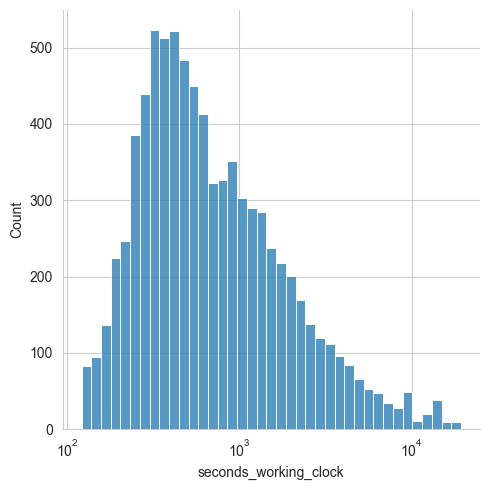

In [18]:
# Visualise data distribution
sns.displot(data_sessions, x="seconds_working_clock",log_scale = True)

We can in the following remove products that have less than 5 data points, as that is a good indicator for missing or bad quality data.

In [19]:
# Remove products with less than five data entries
product_index = data_sessions.groupby("product_id").size()[data_sessions.groupby("product_id").size() > 5].index
data_sessions = data_sessions[data_sessions.product_id.isin(product_index)]

## Check distribution of data samples

To be able to simulate based on the given data we fit distribution over the processing times of each product.

In [20]:
# Test different distributions to fit the data
fit_list = []
products = data_sessions.product_id.drop_duplicates()
for product in tqdm(products):
    X = data_sessions[data_sessions.product_id == product].seconds_working_clock
    for distr in ["gamma", "genextreme", "dweibull", "beta", "norm",
                  "expon","pareto", "lognorm", "t", "uniform"]:
        dist = distfit(alpha=0.05, smooth=10, distr = [distr])
        # Search for best theoretical fit on your empirical data
        dist.fit_transform(X)
        best_distr = dist.model
        fit_dic = {"product": product,
                   "number_samples": len(X),
                   "distr": dist,
                   "type": distr,
                   "score" :  best_distr["score"]}
        fit_list.append(fit_dic)
fit_df = pd.DataFrame(fit_list)

  0%|          | 0/168 [00:00<?, ?it/s]

[distfit] >fit..
[distfit] >transform..
[smoothline] >Smoothing by interpolation..
[distfit] >[gamma] [0.00 sec] [RSS: 4.82682e-06] [loc=123.718 scale=132.488]
[distfit] >Compute confidence interval [parametric]
[distfit] >fit..
[distfit] >transform..
[smoothline] >Smoothing by interpolation..
[distfit] >[genextreme] [0.04 sec] [RSS: 2.2372e-06] [loc=268.605 scale=110.248]
[distfit] >Compute confidence interval [parametric]
[distfit] >fit..
[distfit] >transform..
[smoothline] >Smoothing by interpolation..
[distfit] >[dweibull] [0.00 sec] [RSS: 3.76376e-06] [loc=319.137 scale=128.010]
[distfit] >Compute confidence interval [parametric]
[distfit] >fit..
[distfit] >transform..
[smoothline] >Smoothing by interpolation..
[distfit] >[beta] [0.01 sec] [RSS: 5.24709e-06] [loc=126.052 scale=2100.598]
[distfit] >Compute confidence interval [parametric]
[distfit] >fit..
[distfit] >transform..
[smoothline] >Smoothing by interpolation..
[distfit] >[norm] [0.00 sec] [RSS: 1.05883e-05] [loc=352.919 s

In [21]:
# Check different found distribution fits
fit_df["weighted_score"] = fit_df["number_samples"] * fit_df["score"]
fit_df[fit_df.number_samples > 0].groupby("type").sum().sort_values("weighted_score")

,product,number_samples,score,weighted_score
type,,,,
dweibull,351892.0,7918,0.001614,0.046318
t,351892.0,7918,0.001984,0.057730
norm,351892.0,7918,0.001951,0.058341
beta,351892.0,7918,0.002827,0.058359
gamma,351892.0,7918,0.002421,0.072652
uniform,351892.0,7918,0.004266,0.195766
expon,351892.0,7918,0.006053,0.227401
pareto,351892.0,7918,0.010436,0.274232
genextreme,351892.0,7918,0.010328,0.277449


In [22]:
# Select dweibull distribution
distributions = fit_df[fit_df.type == "dweibull"][["product", "distr"]].drop_duplicates()

In [23]:
# Merge data
sim_data = data_sessions.merge(distributions, left_on="product_id", right_on="product", how = "left")
sim_data.dropna(inplace = True)

In [24]:
# Save data
# with open(r"../data/interim/sim_data.pickle", "wb") as output_file:
#    pickle.dump(sim_data, output_file)